# **Time Series Forecasting**

## **Business Understanding**

Nitrogen Dioksida (NO₂) merupakan salah satu gas pencemar udara yang berkontribusi besar terhadap penurunan kualitas udara dan berdampak negatif terhadap kesehatan manusia. Gas ini umumnya dihasilkan dari aktivitas pembakaran bahan bakar fosil, seperti kendaraan bermotor dan industri.
Pemantauan kadar NO₂ secara berkala menjadi penting untuk mengetahui kondisi kualitas udara di suatu wilayah serta memprediksi tren polusi di masa depan.

Sidayu, yang terletak di Kabupaten Gresik, merupakan daerah dengan aktivitas transportasi dan industri yang meningkat. Namun, pengamatan manual terhadap kualitas udara masih terbatas. Oleh karena itu, pemanfaatan data satelit Sentinel-5P yang menyediakan pengukuran konsentrasi NO₂ secara harian dapat menjadi solusi efektif untuk melakukan analisis berbasis data.

## **Data Understanding**

Data yang digunakan merupakan hasil pengukuran harian konsentrasi **Nitrogen Dioksida (NO₂)** di atmosfer.
Produk **SENTINEL_5P_L2** memiliki beberapa band (kanal pengukuran), namun pada penelitian ini hanya digunakan band “NO2” yang menunjukkan konsentrasi gas NO₂ di permukaan bumi dalam satuan µg/m³.

Data diambil berdasarkan **batas wilayah administratif Kecamatan Sidayu, Kabupaten Gresik**, yang didefinisikan menggunakan Area of Interest (AOI) dalam format GeoJSON.

### Penentuan Area of Interest (AOI)

Wilayah kajian ditentukan menggunakan koordinat geografis batas persegi (bounding box) yang mencakup sebagian besar area Kecamatan Sidayu.
Berikut adalah ilustrasi wilayah observasi yang digunakan untuk pengambilan data:

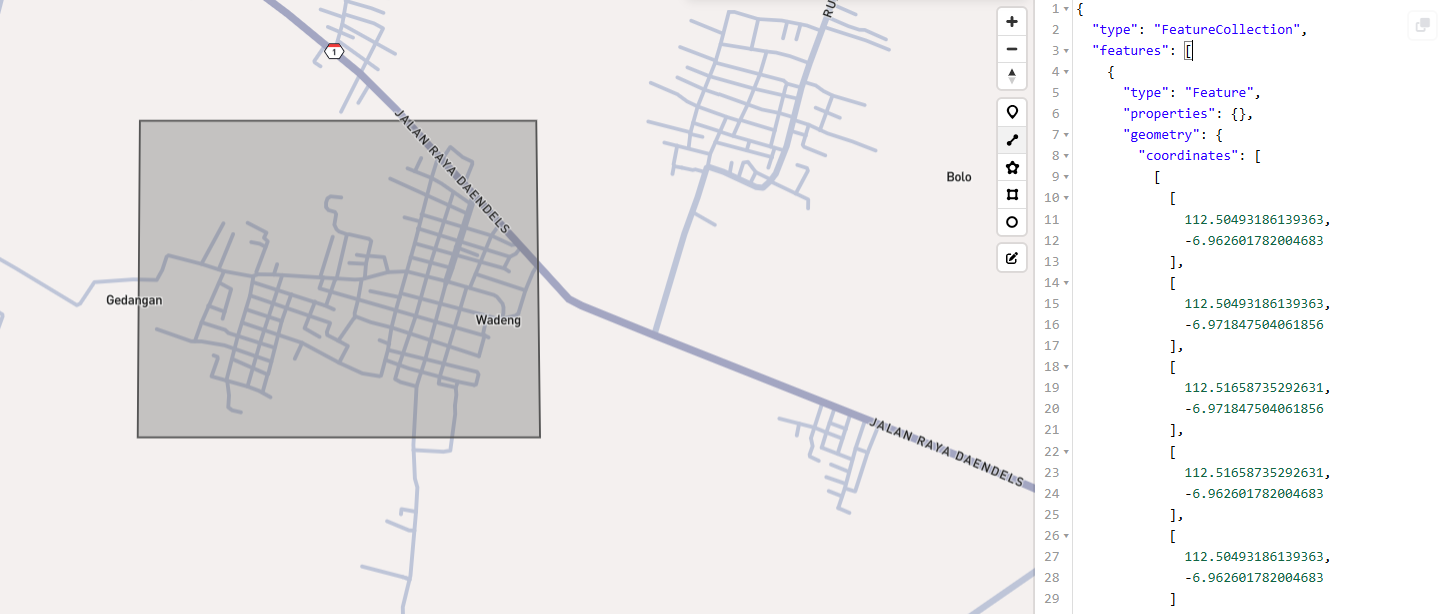

In [4]:
!pip install openeo

In [5]:
import openeo
import pandas as pd
import matplotlib.pyplot as plt
import os

In [6]:
# Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=ZPSO-CBET 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [8]:
# AOI: poligon kedua dari data kamu (Sidayu, Gresik)
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [112.49, -6.94],
            [112.49, -7.02],
            [112.58, -7.02],
            [112.58, -6.94],
            [112.49, -6.94],
        ]
    ],
}

Koordinat tersebut membentuk persegi spasial yang menutupi Desa Gedangan dan Wadeng di Kecamatan Sidayu.
AOI ini digunakan sebagai batas pemrosesan data untuk mengekstraksi nilai rata-rata NO₂ dari citra Sentinel-5P.

### Pengambilan Data Sentinel-5P

Data diambil melalui API openeo.dataspace.copernicus.eu dengan autentikasi **OIDC (OpenID Connect)**.

Kemudian dilakukan pemanggilan koleksi citra `SENTINEL_5P_L2` dengan parameter:

*   `spatial_extent`: batas koordinat AOI (longitude dan latitude),

*   `temporal_extent`: rentang waktu observasi 25 September hingga 25 Oktober 2025,

*   `bands`: hanya menggunakan kanal pengukuran "NO2".

In [9]:
# Ambil data Sentinel-5P (band "NO2")
s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent={
        "west": 112.49,
        "south": -7.02,
        "east": 112.58,
        "north": -6.94,
    },
    temporal_extent=["2024-10-25", "2025-10-25"],
    bands=["NO2"],
)

### Proses Agregasi Data



Karena data satelit biasanya merekam beberapa citra dalam satu hari, dilakukan dua tahap agregasi:

*   Agregasi Temporal (harian):
Mengambil rata-rata nilai NO₂ setiap hari (aggregate_temporal_period).

*   Agregasi Spasial:
Mengambil rata-rata seluruh piksel dalam area AOI (aggregate_spatial).



In [10]:
def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")


### Output Data

Hasil akhir dari proses ini adalah file NetCDF (no2.nc), yang berisi:

*   Tanggal observasi (t)

*   Nilai rata-rata konsentrasi NO₂ (NO2).



In [11]:
job = daily_mean_aoi.execute_batch(out_format="CSV")

results = job.get_results()
results.download_files("data-copernicus")

for f in os.listdir("data-copernicus"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("data-copernicus", f))
        print("File ditemukan:", f)
        break

df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

0:00:00 Job 'j-2511021329304d548fd956b80dd5595b': send 'start'
0:00:13 Job 'j-2511021329304d548fd956b80dd5595b': created (progress 0%)
0:00:19 Job 'j-2511021329304d548fd956b80dd5595b': created (progress 0%)
0:00:25 Job 'j-2511021329304d548fd956b80dd5595b': created (progress 0%)
0:00:33 Job 'j-2511021329304d548fd956b80dd5595b': created (progress 0%)
0:00:43 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:00:55 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:01:11 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:01:30 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:01:55 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:02:25 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:03:02 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:03:49 Job 'j-2511021329304d548fd956b80dd5595b': running (progress N/A)
0:04:47 Job 'j-2511021329304d548fd956b80dd5595b': finished (progr

/tmp/ipython-input-2981875131.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


## **Data Preparation**

Tahap Data Preparation bertujuan untuk menyiapkan data mentah hasil ekstraksi dari Sentinel-5P agar siap digunakan dalam proses pemodelan deret waktu (time series forecasting).
Pada tahap ini dilakukan proses konversi format, seleksi atribut, pembersihan data, dan visualisasi awal.

### Membaca Data

In [22]:
new_df = pd.read_csv('data-copernicus/timeseries.csv')
new_df = new_df.sort_values(by='date').reset_index(drop=True)
new_df['date'] = pd.to_datetime(new_df['date']).dt.date
new_df

,date,feature_index,NO2
0,2024-10-24,0,NaN
1,2024-10-25,0,0.000039
2,2024-10-26,0,0.000062
3,2024-10-27,0,0.000040
4,2024-10-28,0,0.000047
...,...,...,...
361,2025-10-20,0,NaN
362,2025-10-21,0,NaN
363,2025-10-22,0,NaN
364,2025-10-23,0,NaN


### Eksplorasi dan Visualisasi Awal Data

Setelah data dalam format CSV siap, langkah selanjutnya adalah melakukan pemeriksaan kualitas data dan visualisasi awal.
Tahapan ini bertujuan untuk melihat pola perubahan nilai NO₂ dari waktu ke waktu dan memastikan tidak ada anomali data.

📄 5 Data Teratas:
                       date  feature_index       NO2
0 2025-09-08 00:00:00+00:00              0       NaN
1 2025-09-10 00:00:00+00:00              0       NaN
2 2025-09-12 00:00:00+00:00              0  0.000022
3 2025-09-11 00:00:00+00:00              0  0.000021
4 2025-09-06 00:00:00+00:00              0       NaN


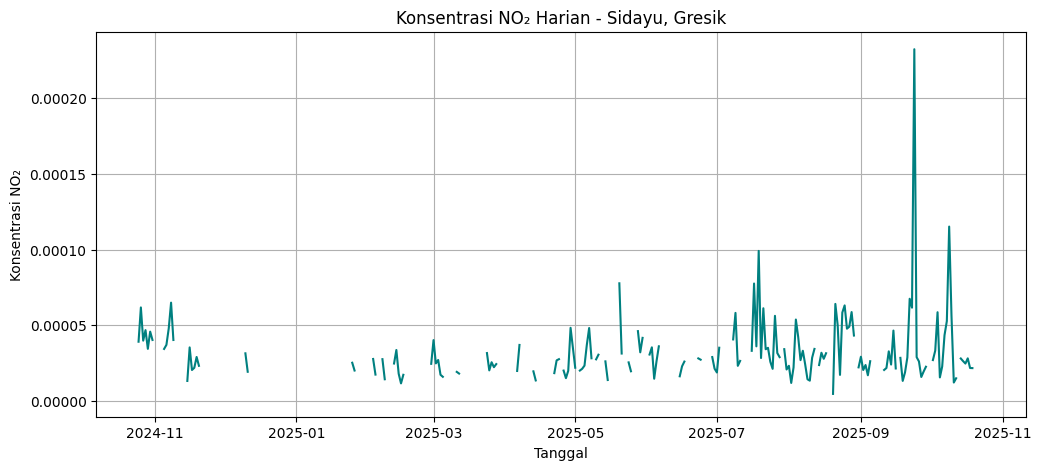

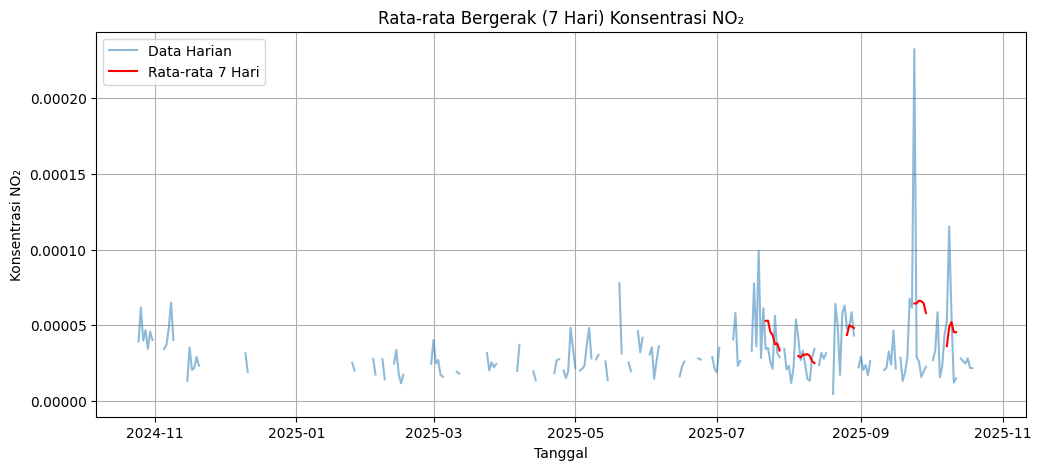

/tmp/ipython-input-2130194303.py:43: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['date'].dt.to_period('M')


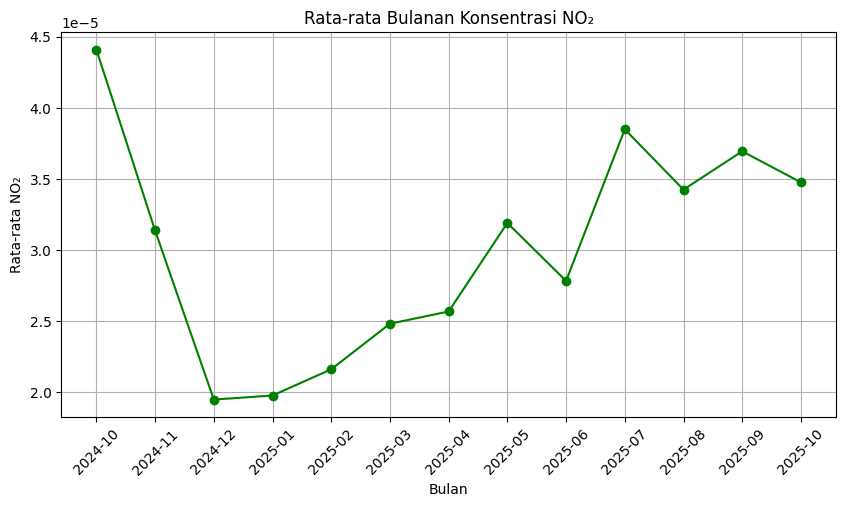

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data-copernicus/timeseries.csv")

df['date'] = pd.to_datetime(df['date'])

print("📄 5 Data Teratas:")
print(df.head())

# --- Jika kolom 'NO2' belum ada, sesuaikan nama kolom hasil Copernicus ---
if 'mean' in df.columns:
    df.rename(columns={'mean': 'NO2'}, inplace=True)

# --- Urutkan berdasarkan tanggal ---
df = df.sort_values(by='date').reset_index(drop=True)

# --- Plot nilai NO₂ harian ---
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['NO2'], color='teal')
plt.title('Konsentrasi NO₂ Harian - Sidayu, Gresik')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂')
plt.grid(True)
plt.show()

# --- Plot rolling mean (rata-rata bergerak 7 hari) ---
df['NO2_rolling'] = df['NO2'].rolling(window=7).mean()

plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['NO2'], alpha=0.5, label='Data Harian')
plt.plot(df['date'], df['NO2_rolling'], color='red', label='Rata-rata 7 Hari')
plt.title('Rata-rata Bergerak (7 Hari) Konsentrasi NO₂')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO₂')
plt.legend()
plt.grid(True)
plt.show()


# --- Tren bulanan (agregasi rata-rata per bulan) ---
df['month'] = df['date'].dt.to_period('M')
df_monthly = df.groupby('month')['NO2'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_monthly['month'].astype(str), df_monthly['NO2'], marker='o', color='green')
plt.title('Rata-rata Bulanan Konsentrasi NO₂')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata NO₂')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Visual menampilkan grafik garis dengan sumbu-X waktu (tanggal observasi) dan sumbu-Y konsentrasi NO₂, menunjukkan pola variasi harian gas polutan di wilayah Sidayu, Gresik selama periode pengamatan.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Cek struktur dan tipe data

Digunakan untuk melihat tipe data setiap kolom (terutama kolom waktu t) serta memastikan tidak ada nilai yang hilang atau salah format.

In [29]:
# --- Informasi umum dataset ---
print("\n📊 Informasi Dataset:")
print(df.info())

# --- Statistik deskriptif (rata-rata, min, max, dll) ---
print("\n📈 Statistik Deskriptif:")
print(df.describe())


📊 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           366 non-null    datetime64[ns, UTC]
 1   feature_index  366 non-null    int64              
 2   NO2            200 non-null    float64            
 3   NO2_rolling    31 non-null     float64            
 4   month          366 non-null    period[M]          
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), period[M](1)
memory usage: 14.4 KB
None

📈 Statistik Deskriptif:
       feature_index         NO2  NO2_rolling
count          366.0  200.000000    31.000000
mean             0.0    0.000031     0.000045
std              0.0    0.000021     0.000013
min              0.0    0.000001     0.000025
25%              0.0    0.000021     0.000032
50%              0.0    0.000027     0.000045
75%              0.0    0.000035     0.00

### Pemeriksaan kelengkapan tanggal (missing dates)

Langkah ini mengecek apakah ada tanggal yang hilang dari rentang waktu pengamatan.
Jika ada tanggal kosong, maka akan diisi atau diinterpolasi pada tahap berikutnya (misalnya sebelum modeling).

In [30]:
# --- Cek apakah ada missing value ---
print("\n🕳️ Cek Missing Value:")
print(df.isnull().sum())


🕳️ Cek Missing Value:
date               0
feature_index      0
NO2              166
NO2_rolling      335
month              0
dtype: int64


## **Pre-Processing**

### Tangani Missing Value dengan Interpolasi

In [33]:
new_df = pd.Series(new_df['NO2'].values, index=new_df['date'], name='NO2')
new_df = new_df.interpolate(method='linear').bfill()
new_df = pd.DataFrame(new_df).reset_index()
new_df.to_csv("data-copernicus/timeseries.csv")
new_df.head(5)

,date,NO2
0,2024-10-24,0.000039
1,2024-10-25,0.000039
2,2024-10-26,0.000062
3,2024-10-27,0.000040
4,2024-10-28,0.000047


### Cek Ulang Missing Value

In [34]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

,Missing Count,Missing Percent (%)
date,0,0.0
NO2,0,0.0


### Visusalisasi setelah menangani missing value

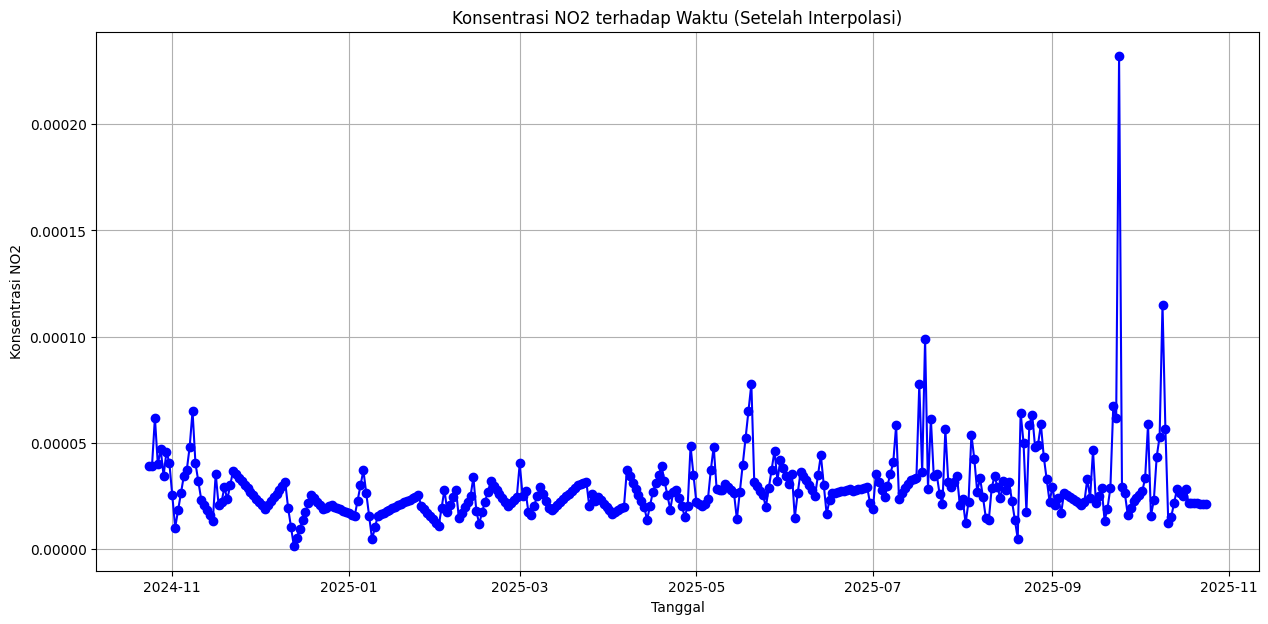

In [35]:
plt.figure(figsize=(15, 7))
plt.plot(new_df['date'], new_df['NO2'], marker='o', linestyle='-', color='blue')
plt.title('Konsentrasi NO2 terhadap Waktu (Setelah Interpolasi)')
plt.xlabel('Tanggal')
plt.ylabel('Konsentrasi NO2')
plt.grid(True)
plt.show()

### Pembentukan Fitur Time Series (Supervised Framing)

Pada tahap ini, data deret waktu (time series) NO₂ diubah menjadi format supervised learning, agar dapat digunakan oleh model prediksi seperti K-Nearest Neighbors (KNN).

Konsep yang digunakan disebut lag features, yaitu membuat fitur dari nilai-nilai NO₂ pada hari-hari sebelumnya untuk memprediksi nilai hari berikutnya. Dalam kode berikut, dibuat tiga kolom baru:

*   h-3: nilai NO₂ tiga hari sebelumnya,

*   h-2: dua hari sebelumnya, dan

*   h-1: satu hari sebelumnya,

*   sementara kolom t berisi nilai NO₂ pada hari yang akan diprediksi.

Proses ini menggunakan fungsi shift() untuk menggeser data sesuai urutan waktu. Setelah itu, baris yang memiliki nilai kosong akibat pergeseran data dihapus menggunakan dropna().

#### Inisialisasi hari ke 2 - 5

In [36]:
h2 = new_df
h3 = new_df
h4 = new_df
h5 = new_df

#### Data Supervised h1 & h2

In [37]:
h2 = h2.drop(columns=['date'])
hari = 2

for i in range(1, hari + 1):
    names = f"h{i}"
    h2[names] = h2['NO2'].shift(i)

h2 = h2.dropna().reset_index(drop=True)
h2

,NO2,h1,h2
0,0.000062,0.000039,0.000039
1,0.000040,0.000062,0.000039
2,0.000047,0.000040,0.000062
3,0.000035,0.000047,0.000040
4,0.000046,0.000035,0.000047
...,...,...,...
359,0.000022,0.000022,0.000022
360,0.000022,0.000022,0.000022
361,0.000021,0.000022,0.000022
362,0.000021,0.000021,0.000022


#### Data Supervised h1, h2, dan h3

In [38]:
h3 = h3.drop(columns=['date'])
hari = 3

for i in range(1, hari + 1):
    names = f"h{i}"
    h3[names] = h3['NO2'].shift(i)

h3 = h3.dropna().reset_index(drop=True)
h3

,NO2,h1,h2,h3
0,0.000040,0.000062,0.000039,0.000039
1,0.000047,0.000040,0.000062,0.000039
2,0.000035,0.000047,0.000040,0.000062
3,0.000046,0.000035,0.000047,0.000040
4,0.000040,0.000046,0.000035,0.000047
...,...,...,...,...
358,0.000022,0.000022,0.000022,0.000028
359,0.000022,0.000022,0.000022,0.000022
360,0.000021,0.000022,0.000022,0.000022
361,0.000021,0.000021,0.000022,0.000022


#### Data Supervised h1, h2, h3, dan h4

In [39]:
h4 = h4.drop(columns=['date'])
hari = 4

for i in range(1, hari + 1):
    names = f"h{i}"
    h4[names] = h4['NO2'].shift(i)

h4 = h4.dropna().reset_index(drop=True)
h4

,NO2,h1,h2,h3,h4
0,0.000047,0.000040,0.000062,0.000039,0.000039
1,0.000035,0.000047,0.000040,0.000062,0.000039
2,0.000046,0.000035,0.000047,0.000040,0.000062
3,0.000040,0.000046,0.000035,0.000047,0.000040
4,0.000025,0.000040,0.000046,0.000035,0.000047
...,...,...,...,...,...
357,0.000022,0.000022,0.000022,0.000028,0.000025
358,0.000022,0.000022,0.000022,0.000022,0.000028
359,0.000021,0.000022,0.000022,0.000022,0.000022
360,0.000021,0.000021,0.000022,0.000022,0.000022


#### Data Supervised h1, h2, h3, h4, dan h5

In [40]:
h5 = h5.drop(columns=['date'])
hari = 5

for i in range(1, hari + 1):
    names = f"h{i}"
    h5[names] = h5['NO2'].shift(i)

h5 = h5.dropna().reset_index(drop=True)
h5

,NO2,h1,h2,h3,h4,h5
0,0.000035,0.000047,0.000040,0.000062,0.000039,0.000039
1,0.000046,0.000035,0.000047,0.000040,0.000062,0.000039
2,0.000040,0.000046,0.000035,0.000047,0.000040,0.000062
3,0.000025,0.000040,0.000046,0.000035,0.000047,0.000040
4,0.000010,0.000025,0.000040,0.000046,0.000035,0.000047
...,...,...,...,...,...,...
356,0.000022,0.000022,0.000022,0.000028,0.000025,0.000026
357,0.000022,0.000022,0.000022,0.000022,0.000028,0.000025
358,0.000021,0.000022,0.000022,0.000022,0.000022,0.000028
359,0.000021,0.000021,0.000022,0.000022,0.000022,0.000022


## **Modeling**

### MAPE

In [41]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Menghitung Mean Absolute Percentage Error (MAPE).
    Menghindari pembagian dengan nol.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Menghindari pembagian dengan nol (jika y_true ada yang 0)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan # Tidak ada data valid untuk dihitung

    # Hitung MAPE hanya pada data yang y_true-nya bukan 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return mape

In [42]:
list_scores = []

### Pembagian Data untuk Pelatihan dan Pengujian

Langkah ini membagi dataset menjadi dua bagian, yaitu data latih (train) dan data uji (test) dengan perbandingan 70:30.
Data latih digunakan untuk melatih model agar dapat mengenali pola dari data historis, sedangkan data uji digunakan untuk mengukur kemampuan model dalam melakukan prediksi terhadap data baru.

Parameter shuffle=False digunakan karena data ini merupakan time series, sehingga urutan waktu harus dipertahankan agar model tidak kehilangan konteks temporalnya.

### Model K-Nearest Neighbors (KNN)

Model **K-Nearest Neighbors (KNN) Regression** digunakan untuk memprediksi konsentrasi NO₂ berdasarkan nilai-nilai historis beberapa hari sebelumnya (`h-3, h-2, h-1`).
Nilai `k` = 7 dipilih untuk mempertimbangkan tujuh tetangga terdekat dalam menentukan prediksi.

Evaluasi model dilakukan menggunakan dua metrik:

*   Mean Squared Error (MSE): mengukur rata-rata kesalahan kuadrat antara nilai aktual dan prediksi.

*   R² Score: menunjukkan seberapa baik model mampu menjelaskan variasi dalam data (semakin mendekati 1, semakin baik).



### Modelling Data h1 dan h2 menggunakan KNN Regression

In [43]:
X = h2.drop(columns=['NO2'])
y = h2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)
h2_predict = knn.predict(X_test_scaled)
r2_h2 = r2_score(y_test, h2_predict)
mse_h2 = mean_squared_error(y_test, h2_predict)

print("MSE:", mse_h2)
print("R2:", r2_h2)

MSE: 9.971525567582374e-11
R2: 0.14187818649676487


### MAPE dengan 2 lag

In [44]:
# --- Modelling Data h1 dan h2 ---
X = h2.drop(columns=['NO2'])
y = h2['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h2 = MinMaxScaler()
X_train_scaled = scaler_h2.fit_transform(X_train)
X_test_scaled = scaler_h2.transform(X_test)

knn_h2 = KNeighborsRegressor(n_neighbors=7)
knn_h2.fit(X_train_scaled, y_train)
h2_predict = knn_h2.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h2 = mean_absolute_percentage_error(y_test, h2_predict)
print(f"MAPE h2: {mape_h2:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h2',  # <-- Label yang benar
    'MAPE': mape_h2
}
list_scores.append(scores)

MAPE h2: 31.08 %


### Modelling Data h1, h2, dan h3 menggunakan K-NN Regression

In [46]:
X = h3.drop(columns=['NO2'])
y = h3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h3_predict = knn.predict(X_test_scaled)
r2_h3 = r2_score(y_test, h3_predict)
mse_h3 = mean_squared_error(y_test, h3_predict)

print("MSE:", mse_h3)
print("R²:", r2_h3)

MSE: 1.5703997034428615e-10
R²: 0.10961363257855661


### MAPE dengan 3 lag

In [47]:
# --- Modelling Data h1 dan h3 ---
X = h3.drop(columns=['NO2'])
y = h3['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h3 = MinMaxScaler()
X_train_scaled = scaler_h3.fit_transform(X_train)
X_test_scaled = scaler_h3.transform(X_test)

knn_h3 = KNeighborsRegressor(n_neighbors=7)
knn_h3.fit(X_train_scaled, y_train)
h3_predict = knn_h3.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h3 = mean_absolute_percentage_error(y_test, h3_predict)
print(f"MAPE h3: {mape_h3:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h3',  # <-- Label yang benar
    'MAPE': mape_h3
}
list_scores.append(scores)

MAPE h3: 28.19 %


### Modelling Data h1, h2, h3, dan h4 menggunakan K-NN Regression

In [48]:
X = h4.drop(columns=['NO2'])
y = h4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h4_predict = knn.predict(X_test_scaled)
r2_h4 = r2_score(y_test, h4_predict)
mse_h4 = mean_squared_error(y_test, h4_predict)

print("MSE:", mse_h4)
print("R²:", r2_h4)

MSE: 1.832063639744082e-10
R²: 0.06066513786520367


### MAPE dengan 4 lag

In [49]:
# --- Modelling Data h1 dan h4 ---
X = h4.drop(columns=['NO2'])
y = h4['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h4 = MinMaxScaler()
X_train_scaled = scaler_h4.fit_transform(X_train)
X_test_scaled = scaler_h4.transform(X_test)

knn_h4 = KNeighborsRegressor(n_neighbors=7)
knn_h4.fit(X_train_scaled, y_train)
h4_predict = knn_h4.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h4 = mean_absolute_percentage_error(y_test, h4_predict)
print(f"MAPE h4: {mape_h4:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h4',  # <-- Label yang benar
    'MAPE': mape_h4
}
list_scores.append(scores)

MAPE h4: 48.30 %


### Modelling Data h1 h2, h3, h4, dan h5 menggunakan K-NN Regression

In [50]:
X = h5.drop(columns=['NO2'])
y = h5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 🔹 Ganti scaler di sini
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Model KNN
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

# 🔹 Prediksi & evaluasi
h5_predict = knn.predict(X_test_scaled)
r2_h5 = r2_score(y_test, h5_predict)
mse_h5 = mean_squared_error(y_test, h5_predict)

print("MSE:", mse_h5)
print("R²:", r2_h5)

MSE: 1.8576236696976985e-10
R²: -0.057079032973084365


### MAPE dengan 5 lag

In [51]:
# --- Modelling Data h1 dan h5 ---
X = h5.drop(columns=['NO2'])
y = h5['NO2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_h5 = MinMaxScaler()
X_train_scaled = scaler_h5.fit_transform(X_train)
X_test_scaled = scaler_h5.transform(X_test)

knn_h5 = KNeighborsRegressor(n_neighbors=7)
knn_h5.fit(X_train_scaled, y_train)
h5_predict = knn_h5.predict(X_test_scaled)

# --- Perhitungan MAPE ---
mape_h5 = mean_absolute_percentage_error(y_test, h5_predict)
print(f"MAPE h5: {mape_h5:.2f} %")

# --- Simpan Skor ---
scores = {
    'Lag': 'h1-h5',  # <-- Label yang benar
    'MAPE': mape_h5
}
list_scores.append(scores)

MAPE h5: 60.00 %


### Perbandingan nilai R2

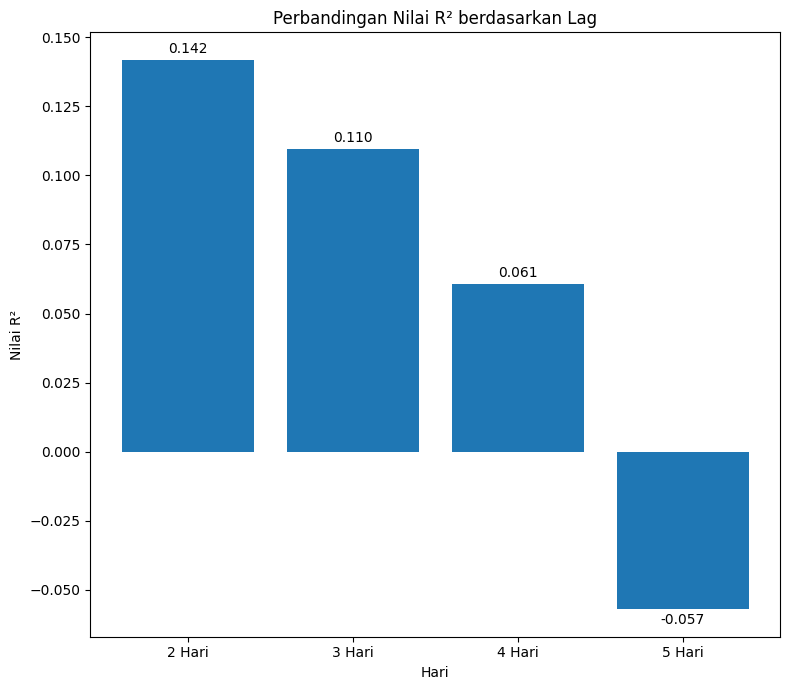

In [52]:
x = ['2 Hari', '3 Hari', '4 Hari', '5 Hari']
y = [r2_h2, r2_h3, r2_h4, r2_h5]
knn = KNeighborsRegressor(n_neighbors=2)

fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(x, y)

ax.set_title("Perbandingan Nilai R² berdasarkan Lag")
ax.set_xlabel("Hari")
ax.set_ylabel("Nilai R²")

ax.bar_label(bars, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

### Perbandingan MAPE tiap lag


Data yang Digunakan untuk Chart (Urutan Eksekusi):
| Lag   |    MAPE |
|:------|--------:|
| h1-h2 | 31.0781 |
| h1-h3 | 28.1866 |
| h1-h4 | 48.2966 |
| h1-h5 | 59.9990 |


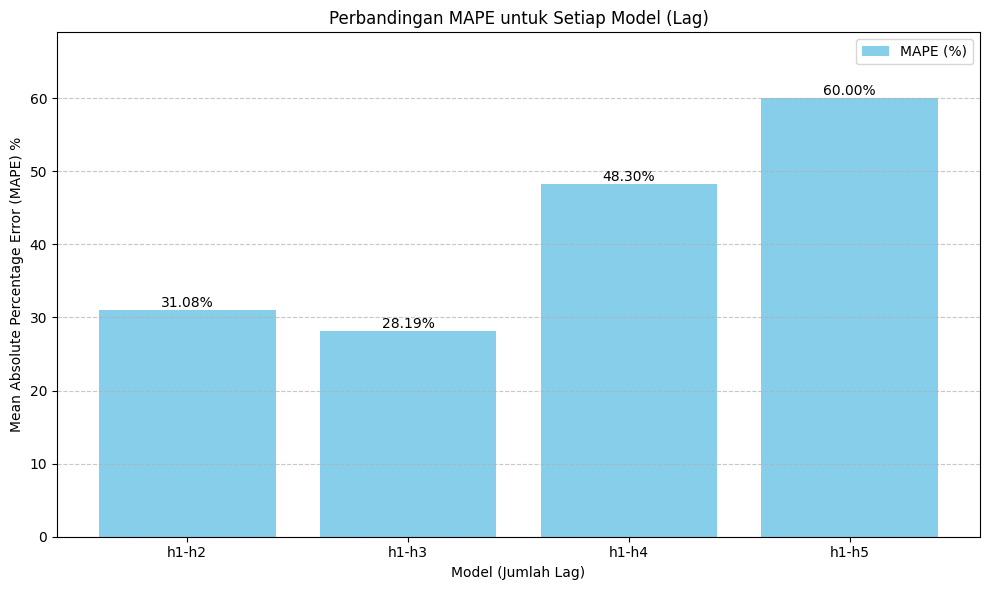

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

try:
    # Mengubah list of dictionaries menjadi DataFrame
    scores_df = pd.DataFrame(list_scores)

    # --- Membuat Bar Chart ---
    plt.figure(figsize=(10, 6))

    # Gunakan 'scores_df' (bukan scores_df_sorted) untuk plotting
    bars = plt.bar(scores_df['Lag'], scores_df['MAPE'], color='skyblue', label='MAPE (%)')

    # Menambahkan label nilai di atas setiap bar
    for bar in bars:
        yval = bar.get_height()
        # Menampilkan nilai MAPE dengan 2 angka desimal
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}%', va='bottom', ha='center')

    plt.title('Perbandingan MAPE untuk Setiap Model (Lag)')
    plt.xlabel('Model (Jumlah Lag)')
    plt.ylabel('Mean Absolute Percentage Error (MAPE) %')

    # Atur batas Y (menggunakan scores_df)
    if not scores_df.empty:
        plt.ylim(0, max(scores_df['MAPE']) * 1.15)
    else:
        plt.ylim(0, 10) # Batas default jika data kosong

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()


    # Menampilkan tabel data (menggunakan scores_df)
    print("\nData yang Digunakan untuk Chart (Urutan Eksekusi):")
    print(scores_df.to_markdown(index=False, floatfmt=".4f"))

    plt.show() # <-- Menampilkan chart

except NameError:
    print("--- ERROR ---")
    print("Variabel 'list_scores' belum terdefinisi.")
    print("Pastikan Anda sudah menjalankan cell-cell modelling (h2, h3, h4, h5) sebelumnya.")
except Exception as e:
    print(f"Terjadi error: {e}")
    print("Pastikan 'list_scores' Anda berisi data yang valid.")

### Output untuk Prediksi Hari Berikutnya

In [54]:
# --- Prediksi Hari Berikutnya (Versi Perbaikan) ---

# 1. Ambil 3 nilai NO2 terakhir
last_3_values = new_df['NO2'].values[-3:]
print(f"Data input (3 hari terakhir)")

# 2. TENTUKAN NAMA FITUR (sesuai dengan model h1-h3)
#    (Ini adalah kolom X dari cell modelling h3 Anda)
feature_names = ['h1', 'h2', 'h3']

# 3. Ubah input menjadi DataFrame DENGAN NAMA FITUR
input_df = pd.DataFrame([last_3_values], columns=feature_names)

# 4. Scale data input menggunakan scaler yang sesuai (scaler_h3)
try:
    # Sekarang scaler akan melihat nama kolom dan tidak akan warning
    input_data_scaled = scaler_h3.transform(input_df)

    # 5. Buat prediksi menggunakan model terbaik Anda (knn_h3)
    predicted_no2 = knn_h3.predict(input_data_scaled)

    print("\n--- HASIL PREDIKSI ---")
    print(f"Prediksi konsentrasi NO2 untuk hari berikutnya adalah: {predicted_no2[0]:.8f}")

except NameError as e:
    print(f"\n--- ERROR ---")
    print(f"Error: {e}. Pastikan variabel 'scaler_h3' dan 'knn_h3' sudah terdefinisi")
    print("dari cell modelling h1-h3 Anda.")
except Exception as e:
    print(f"\nTerjadi error lain: {e}")

Data input (3 hari terakhir)

--- HASIL PREDIKSI ---
Prediksi konsentrasi NO2 untuk hari berikutnya adalah: 0.00002253


### Cek apakah kadar NO2 hari berikutnya baik atau tidak baik

In [55]:
# Asumsi 'predicted_no2' adalah list/array berisi [0.00003765]
# Asumsi 'new_df' adalah DataFrame Anda yang sudah bersih
try:
    pred_value = predicted_no2[0]

    # 1. Hitung ambang batas statistik dari data historis Anda (new_df)

    # Median (50% data berada di bawah nilai ini)
    median_val = new_df['NO2'].quantile(0.50)

    # Kuantil Atas (75% data berada di bawah nilai ini)
    upper_quantile_val = new_df['NO2'].quantile(0.75)

    print(f"Nilai Prediksi \t\t: {pred_value:.8f} mol/m^2")
    print(f"Median Historis (Batas 'Baik')\t: {median_val:.8f} mol/m^2")
    print(f"Kuantil Atas (Batas 'Sedang')\t: {upper_quantile_val:.8f} mol/m^2")

    # 2. Buat kategori berdasarkan perbandingan
    if pred_value <= median_val:
        kategori = "Baik"
        penjelasan = f"Nilai ini berada di bawah atau sama dengan batas baik."
    elif pred_value <= upper_quantile_val:
        kategori = "Sedang"
        penjelasan = f"Nilai ini di atas median, tapi di bawah kuantil atas ({upper_quantile_val:.8f})."
    else:
        kategori = "Tinggi (Tidak Baik)"
        penjelasan = f"Nilai ini berada di atas 75% dari data historis Anda (lebih tinggi dari {upper_quantile_val:.8f})."

    print("\n-------------------------------------------------")
    print(f"Kategori Prediksi : **{kategori}**")
    print(f"Penjelasan: {penjelasan}")
    print("-------------------------------------------------")

except NameError:
    print("Error: Pastikan variabel 'predicted_no2' dan 'new_df' sudah ada.")
except Exception as e:
    print(f"Terjadi error: {e}")

Nilai Prediksi 		: 0.00002253 mol/m^2
Median Historis (Batas 'Baik')	: 0.00002545 mol/m^2
Kuantil Atas (Batas 'Sedang')	: 0.00003164 mol/m^2

-------------------------------------------------
Kategori Prediksi : **Baik**
Penjelasan: Nilai ini berada di bawah atau sama dengan batas baik.
-------------------------------------------------


## **Deployment**

In [56]:
import joblib

# Simpan model dan scaler ke file
joblib.dump(knn_h3, "model_h3.pkl")
joblib.dump(scaler_h3, "scaler_h3.pkl")

# Simpan dataset hasil olahan (new_df)
new_df.to_csv("data_no2.csv", index=False)

print("✅ File berhasil disimpan:")
print("- model_h3.pkl")
print("- scaler_h3.pkl")
print("- data_no2.csv")


✅ File berhasil disimpan:
- model_h3.pkl
- scaler_h3.pkl
- data_no2.csv


### Code Streamlit

untuk codenya dapat dilihat dari link github : https://github.com/Pras7804/polusi-udara-NO2

Lalu untuk websitenya dapat di akses melalui link https://forecasting-no2-230411100099.streamlit.app/